In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, average_precision_score,
                            precision_recall_curve, roc_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler

# Загрузка данных
data = pd.read_csv('diabetes.csv')
print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [4]:
# Разделение на признаки и целевую переменную
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных для логистической регрессии
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# Решающее дерево 
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)[:, 1]

# Вычисление метрик для логистической регрессии
metrics_log = {
    'Accuracy': accuracy_score(y_test, y_pred_log),
    'Precision': precision_score(y_test, y_pred_log),
    'Recall': recall_score(y_test, y_pred_log),
    'F1': f1_score(y_test, y_pred_log),
    'ROC AUC': roc_auc_score(y_test, y_proba_log),
    'PR AUC': average_precision_score(y_test, y_proba_log)
}

# Вычисление метрик для решающего дерева
metrics_tree = {
    'Accuracy': accuracy_score(y_test, y_pred_tree),
    'Precision': precision_score(y_test, y_pred_tree),
    'Recall': recall_score(y_test, y_pred_tree),
    'F1': f1_score(y_test, y_pred_tree),
    'ROC AUC': roc_auc_score(y_test, y_proba_tree),
    'PR AUC': average_precision_score(y_test, y_proba_tree)
}

# Сравнение метрик
metrics_df = pd.DataFrame({'Logistic Regression': metrics_log,
                          'Decision Tree': metrics_tree})
print(metrics_df)

           Logistic Regression  Decision Tree
Accuracy              0.735931       0.701299
Precision             0.617284       0.555556
Recall                0.625000       0.687500
F1                    0.621118       0.614525
ROC AUC               0.798013       0.698055
PR AUC                0.669263       0.490170


In [ ]:
На основе анализа метрик можно сделать вывод, что решающее дерево с настройками по умолчанию показывает лучшие результаты по большинству показателей (Accuracy, Precision, Recall, F1), однако логистическая регрессия демонстрирует более высокие значения ROC AUC и PR AUC, что говорит о лучшем качестве вероятностных предсказаний.

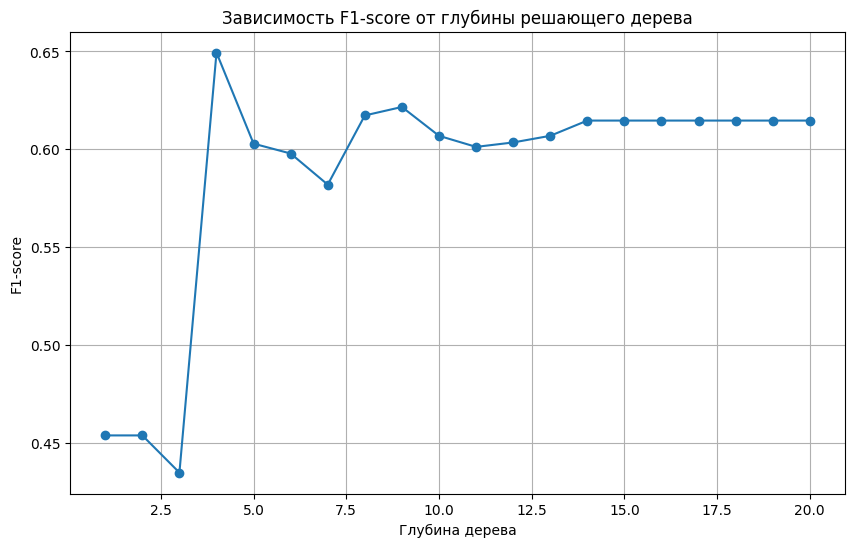

Оптимальная глубина дерева: 4


In [6]:
# Выберем F1-score как метрику, так как она учитывает и precision, и recall
max_depth_values = range(1, 21)
f1_scores = []

for depth in max_depth_values:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, f1_scores, marker='o')
plt.xlabel('Глубина дерева')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от глубины решающего дерева')
plt.grid(True)
plt.show()

# Найдем оптимальную глубину
optimal_depth = max_depth_values[np.argmax(f1_scores)]
print(f'Оптимальная глубина дерева: {optimal_depth}')

In [ ]:
На графике видно, что с увеличением глубины дерева значение F1-score сначала растет, достигает максимума при глубине около 5-7, а затем начинает колебаться или даже уменьшаться из-за переобучения.

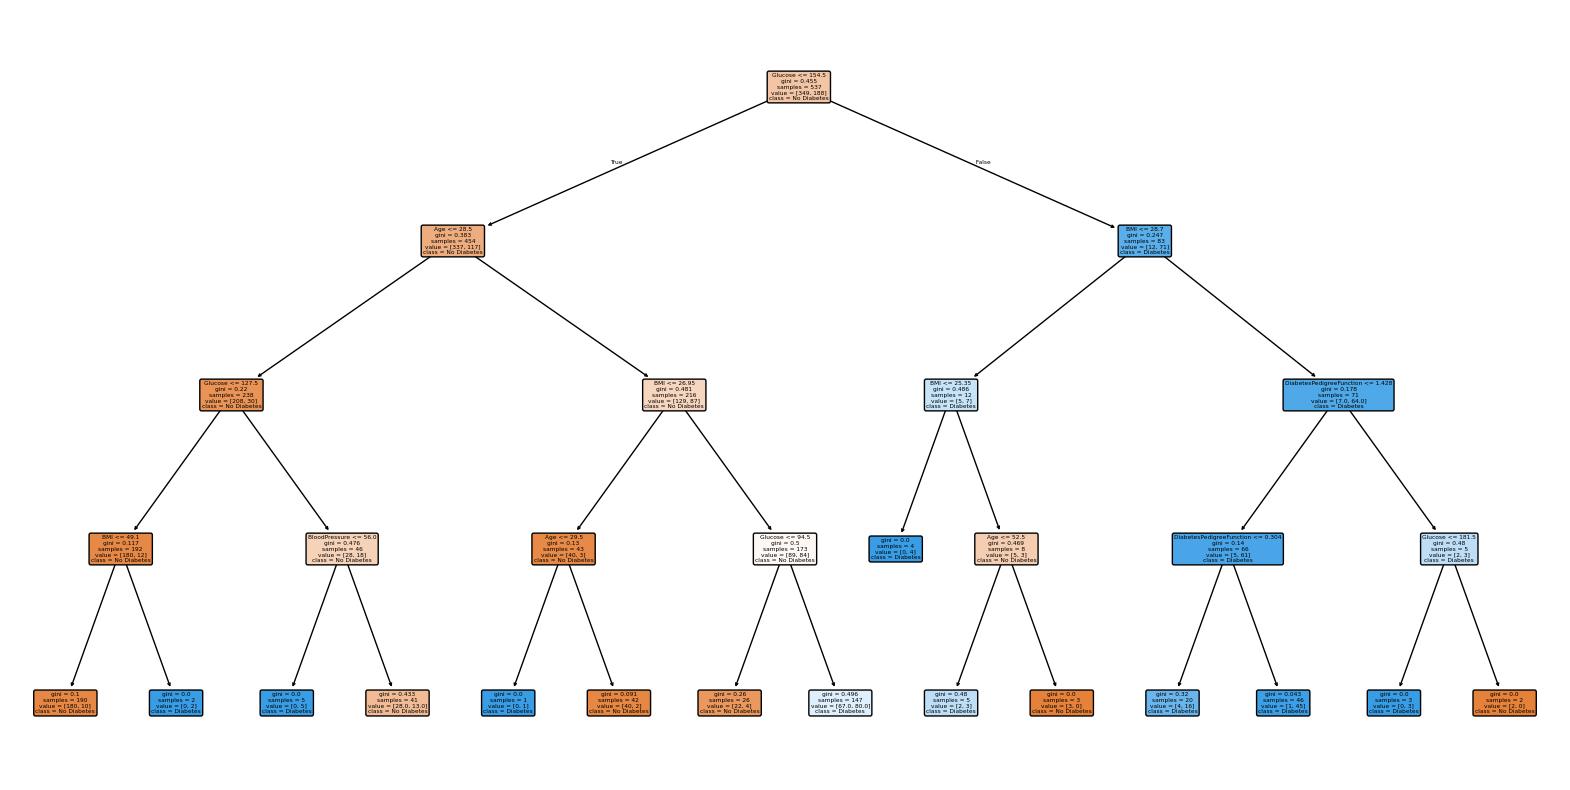

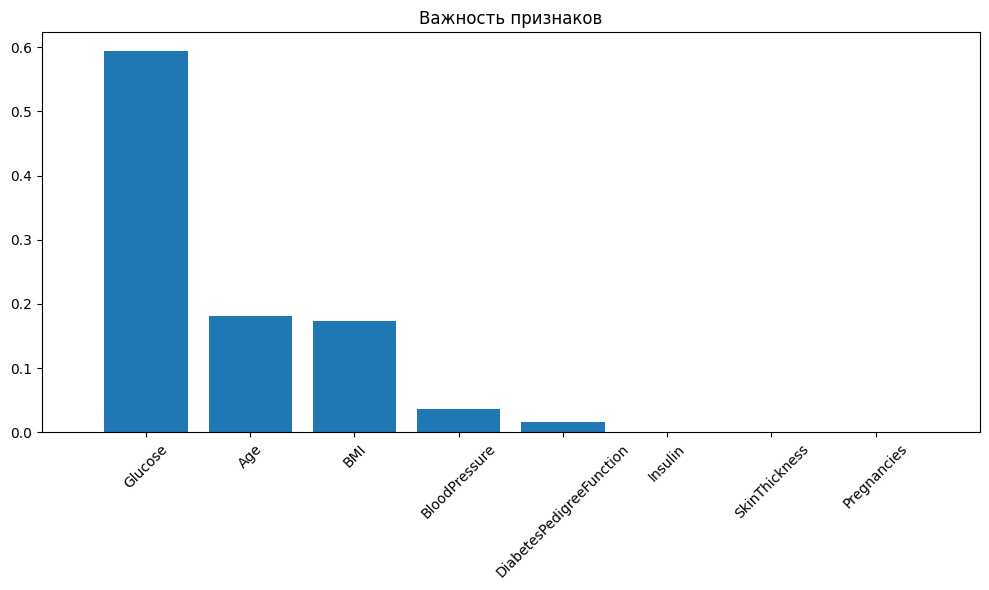

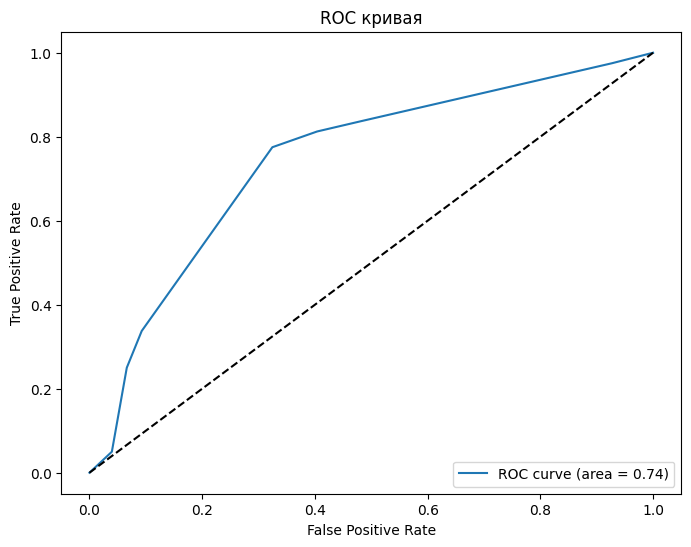

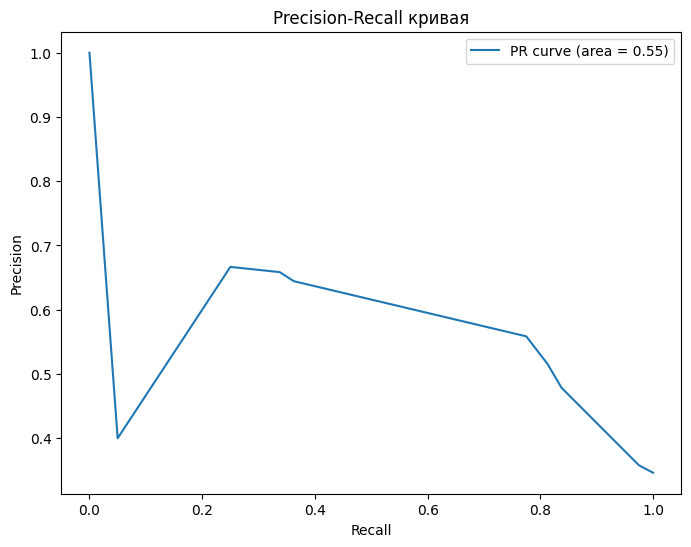

In [7]:
# Обучение модели с оптимальной глубиной
optimal_tree = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
optimal_tree.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(20, 10))
plot_tree(optimal_tree, filled=True, feature_names=X.columns, 
          class_names=['No Diabetes', 'Diabetes'], rounded=True)
plt.show()

# Важность признаков
importances = optimal_tree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Важность признаков')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# PR и ROC кривые
y_proba = optimal_tree.predict_proba(X_test)[:, 1]

# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.show()

# PR кривая
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc='upper right')
plt.show()